# Model Explanation Multiclass

## Dataset & Model Loading

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from treeinterpreter import treeinterpreter as ti
from IPython.display import display
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.text_preprocessing import preprocess_text
from utils.bad_word_blurrer import blur_text
import warnings



df_train = pd.read_csv("../dataset/training_set.csv")
df_train["text"] = df_train["text"].apply(preprocess_text)
df_voc = df_train[df_train["multiclass_label"] != "not_cyberbullying"].copy()
label2id = {label: idx for idx, label in enumerate(sorted(df_voc["multiclass_label"].unique()))}

df_filtered = pd.read_csv("../dataset/true_positive.csv")
df_filtered["text"] = df_filtered["text"].apply(preprocess_text)
df_filtered["label_id"] = df_filtered["multiclass_label"].map(label2id)

X_text = df_filtered["text"]
y_multiclass = df_filtered["label_id"]

pipeline_multiclass = joblib.load("../model/multiclass/RandomForest_TF-IDF_multiclass.pkl")
pipeline_binary = joblib.load("../model/binary/RandomForest_TF-IDF.pkl")
rf_model = pipeline_multiclass.named_steps["model"]       
lr_binary = pipeline_binary.named_steps["model"]          

tfidf_vectorizer = pipeline_multiclass.named_steps["vectorizer"]
BoW_vectorizer_binary = pipeline_binary.named_steps["vectorizer"]

print("Multiclass pipeline steps:")
print(pipeline_multiclass.steps)
print("\nBinary pipeline steps:")
print(pipeline_binary.steps)

print("\nExtracted model types:")
print("Multiclass model:", type(rf_model))
print("Binary model:   ", type(lr_binary))

print("\nMulticlass vocab size:", len(tfidf_vectorizer.get_feature_names_out()))
print("Binary vocab size:   ", len(BoW_vectorizer_binary.get_feature_names_out()))



Multiclass pipeline steps:
[('preprocessing', TextPreprocessor()), ('augment', SynonymAugmenterToBalance()), ('vectorizer', TfidfVectorizer(min_df=0.005)), ('model', RandomForestClassifier(n_estimators=500, random_state=42))]

Binary pipeline steps:
[('preprocessing', TextPreprocessor()), ('augment', SynonymAugmenterToBalance()), ('vectorizer', TfidfVectorizer(min_df=0.005)), ('model', RandomForestClassifier(class_weight='balanced', n_estimators=500,
                       random_state=42))]

Extracted model types:
Multiclass model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Binary model:    <class 'sklearn.ensemble._forest.RandomForestClassifier'>

Multiclass vocab size: 419
Binary vocab size:    321


## Local Multiclass Model Explanation

In [2]:
pd.set_option("display.max_rows", 400)
pd.set_option("display.max_columns", 0)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.expand_frame_repr", False)

df_correct_examples = pd.read_csv("../dataset/selected_explanable_example.csv")

X_example_tfidf = tfidf_vectorizer.transform(df_correct_examples["text"]).toarray().astype("float32")
feature_names = tfidf_vectorizer.get_feature_names_out() 

for i in range(len(df_correct_examples)-1):
    label_id = df_correct_examples.loc[i, "label_id"]
    label_name = df_correct_examples.loc[i, "label_name"]
    text = df_correct_examples.loc[i, "text"]
    
    x = X_example_tfidf[i].reshape(1, -1)

    prediction, bias, contributions = ti.predict(rf_model, x)
    predicted_label_id = np.argmax(prediction)

    data = []
    for j in range(len(feature_names)):
        data.append({
            "feature": blur_text(feature_names[j]),
            "contribution": contributions[0][j][predicted_label_id], 
            "tfidf_value": x[0][j]
        })

    df_interp = pd.DataFrame(data)
    df_interp_sorted = df_interp.reindex(df_interp.contribution.abs().sort_values(ascending=False).index)

    print(f"\n=== TreeInterpreter Explanation ===")
    print(f"True class: {label_id} ({label_name})")
    print(f"Predicted class: {predicted_label_id}")
    print(f"Text preview: {text[:150]}...\n")
    print(f"Bias (expected value): {bias[0][predicted_label_id]:.4f}")
    print(f"Prediction (probabilities): {prediction[0]}")
    
    display(df_interp_sorted.head(25))
    print("=" * 100)



=== TreeInterpreter Explanation ===
True class: 0 (age)
Predicted class: 0
Text preview: realli hope bulli gay school...

Bias (expected value): 0.2014
Prediction (probabilities): [0.94  0.002 0.018 0.032 0.008]


,feature,contribution,tfidf_value
309,school,0.471881,0.305618
41,bulli,0.298121,0.288975
153,high,-0.050404,0.000000
123,g*y,-0.049630,0.382436
292,r**e,0.036280,0.000000
125,girl,-0.032076,0.000000
162,hope,-0.028683,0.638348
183,joke,0.027047,0.000000
249,n****r,0.006126,0.000000
227,middl,-0.005809,0.000000



=== TreeInterpreter Explanation ===
True class: 1 (ethnicity)
Predicted class: 1
Text preview: dumb nigger fuck...

Bias (expected value): 0.2002
Prediction (probabilities): [0. 1. 0. 0. 0.]


,feature,contribution,tfidf_value
83,dumb,0.306914,0.597156
249,n****r,0.284339,0.589131
118,f**k,0.163256,0.544361
41,bulli,0.017411,0.000000
21,a*s,-0.013759,0.000000
309,school,0.012358,0.000000
35,black,-0.007405,0.000000
238,muslim,0.006729,0.000000
252,obama,-0.005585,0.000000
183,joke,0.005193,0.000000



=== TreeInterpreter Explanation ===
True class: 2 (gender)
Predicted class: 2
Text preview: rt im sexist hate woman sport comment...

Bias (expected value): 0.1954
Prediction (probabilities): [0.    0.    0.996 0.004 0.   ]


,feature,contribution,tfidf_value
316,sexist,0.434049,0.437388
303,rt,0.126326,0.322707
400,woman,0.080161,0.405148
171,im,0.059833,0.317408
183,joke,-0.028622,0.000000
292,r**e,-0.027592,0.000000
123,g*y,-0.026484,0.000000
52,christian,0.021212,0.000000
41,bulli,0.020316,0.000000
302,right,0.018977,0.000000



=== TreeInterpreter Explanation ===
True class: 3 (other_cyberbullying)
Predicted class: 3
Text preview: ugli ass think god roll call...

Bias (expected value): 0.2015
Prediction (probabilities): [0.004      0.028      0.129      0.82833333 0.01066667]


,feature,contribution,tfidf_value
43,call,-0.114861,0.349097
34,b***h,0.039832,0.000000
376,ugli,0.039657,0.551376
83,dumb,0.038452,0.000000
249,n****r,0.037745,0.000000
309,school,0.035264,0.000000
238,muslim,0.031862,0.000000
118,f**k,0.029084,0.000000
107,femal,0.027980,0.000000
396,white,0.027210,0.000000



=== TreeInterpreter Explanation ===
True class: 4 (religion)
Predicted class: 4
Text preview: visit muslim countri see woke right your behead like british girl idiot thought vacat morocco good idea dont blond err mean stupid...

Bias (expected value): 0.2015
Prediction (probabilities): [0.012 0.018 0.008 0.006 0.956]


,feature,contribution,tfidf_value
238,muslim,0.344232,0.201951
168,idiot,0.265007,0.211192
302,right,0.057681,0.244640
62,countri,0.042594,0.307403
125,girl,-0.039078,0.190368
41,bulli,0.025954,0.000000
52,christian,-0.021484,0.000000
309,school,0.018435,0.000000
176,islam,-0.013015,0.000000
153,high,0.011257,0.000000


## Global Multiclass Model Explanation

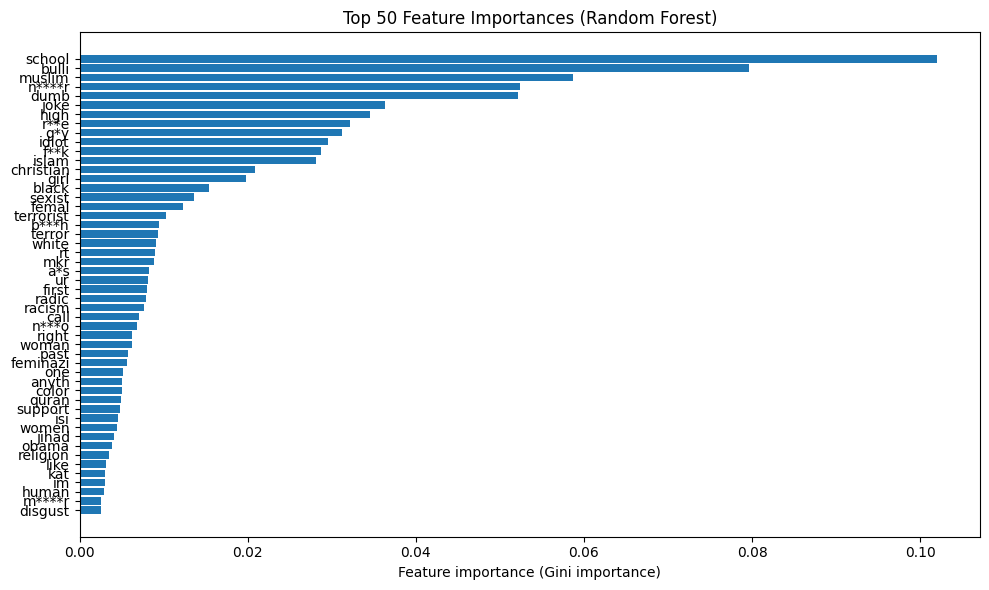

In [3]:
warnings.filterwarnings("ignore")

importances = rf_model.feature_importances_

feature_names = tfidf_vectorizer.get_feature_names_out()

df_importances = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

top_k = 50
df_top = df_importances.head(top_k)

df_top["feature"] = df_top["feature"].apply(blur_text)

plt.figure(figsize=(10, 6))
plt.barh(df_top["feature"][::-1], df_top["importance"][::-1])
plt.xlabel("Feature importance (Gini importance)")
plt.title("Top 50 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


